## AML - Homework 4 Question 1

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
# Install necessary libraries if not already installed
# !pip install transformers torchvision pillow requests
# !pip install transformers torchvision pillow requests
# !pip install --upgrade torch torchvision
# !pip install scikit-learn

# Import required libraries
import torch
from PIL import Image
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import pandas as pd
import csv

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np


## Q1.

Your objective is to evaluate a pre-trained CLIP model (with either CNN or ViT backbone) on the ModelvsBaby dataset: https://osf.io/ba4g2

1. From Huggingface (https://huggingface.co/Links to an external site.) select and download a pre-trained CLIP model (you can use your own computer, Colab, Kaggle... to store the model). Describe the model you downloaded - what is its architecture (e.g. CNN/ViT), number of layers, parameters per layer - breakdown the parameters and explain what they are doing (e.g. are they parts of K, Q and V matrices, bias, feature maps, dense layer...). [10 points]

Model downloaded from the following URL: https://huggingface.co/openai/clip-vit-large-patch14

In [15]:
# Load the pre-trained CLIP model and processor
model_name = "openai/clip-vit-large-patch14"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

### Model Selection and Description
- **Selected Model**: We have selected the pre-trained CLIP model `openai/clip-vit-large-patch14` from Hugging Face.
- **Architecture**: The model is using Vision Transformer (ViT-Large) for the vision encoder and Transformer-based architecture for the text encoder.
- **Purpose**: The model aligns image and text embeddings into a shared space for tasks like zero-shot classification and image-text retrieval.

---

### Architecture Details
1. **Vision Encoder**:
   - **Backbone**: Vision Transformer (ViT).
   - **Input Size**: $224 \times 224$, split into patches of size $14 \times 14$.
   - **Layers**: 24 transformer layers with multi-head attention.

2. **Text Encoder**:
   - **Transformer-based architecture**: Similar to GPT-2.
   - **Input**: Token embeddings and positional encodings for text.
   - **Layers**: 12 transformer layers with multi-head attention.

---

### Parameter Breakdown
1. **Vision Encoder**:
   - **Components**: Patch embedding, attention (K, Q, V matrices), and feed-forward networks.
   - **Total Parameters**: ~304M.

2. **Text Encoder**:
   - **Components**: Token embedding, attention (K, Q, V matrices), and feed-forward networks.
   - **Total Parameters**: ~123M.

3. **Projection Layers**:
   - Combine image and text embeddings into a shared space with a small number of additional parameters.
   - **Total Parameters**: ~1M.

---

### Explanation of Components
- **K, Q, V Matrices**: Used in multi-head attention for capturing relationships between elements (patches for vision or tokens for text).
- **Attention Scores**: These are calculated by taking the dot product of the query and key matrices. They represent the relevance of one token to another.
- **Bias and LayerNorm**: Ensure numerical stability and model robustness.
- **Feed-Forward Layers**: Capture non-linear transformations and interdependencies between features.

---

### Summary
- **Total Parameters**: ~428M, broken down into:
  - Vision Encoder: ~304M.
  - Text Encoder: ~123M.
  - Projection Layers: ~1M.
- **Functionality**: The model aligns image and text features to calculate cosine similarity between embeddings, enabling tasks like zero-shot classification.


## Q2. 

The dataset contains images from the following eight categories: airplane, car, chair, cup, dog, donkey, duck and hat. Each category contains images in five different conditions: realistic, geons, silhouettes, blured and features. Evaluate the model for each condition separately. For each image in the dataset, feed the image into the model together with a text label of a particular category (for each image, evaluate labels of all eight categories). If the model outputs highest correlation for the correct label, consider that as correct classification and otherwise as incorrect classification. Quantify model accuracy for each of the five conditions. [15 points]

In which conditions is your models better/worse/similar to babies (Fig. 3A in this paper: https://osf.io/preprints/psyarxiv/83gae

#### Run the following lines of code if you are using google colab:

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Define dataset directory CHANGE IT TO YOUR DIRECTORY
# dataset_dir = "/content/drive/MyDrive/Applied Machine Learning/Homework 4/data"

#### Skip the below lines of code if using google colab ( here we are getting dataset from local computer)
This is for those who are loading data from computers instead of drive.

In [16]:
# Define dataset directory CHANGE IT TO YOUR DIRECTORY
dataset_dir = "/Users/nishasarwar/Documents/1.AML/Course Work/Homework4/data"

In [17]:
# Define categories and conditions
categories = ["airplane", "car", "chair", "cup", "dog", "donkey", "duck", "hat"]
conditions = ["realistic", "geons", "silhouettes", "blurred", "features"]


# Define image transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for clip-vit-large-patch14
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to match CLIP expectations
])

# Function to infer the category from the filename
def infer_category_from_filename(filename):
    for category in categories:
        if category.lower() in filename.lower():
            return category
    return None  # Return None if the category cannot be inferred

# Function to evaluate the model for a single condition
def evaluate_condition(condition):
    correct = 0
    total = 0

    # Path to the folder for this condition
    condition_dir = os.path.join(dataset_dir, condition)
    if not os.path.exists(condition_dir):
        print(f"Condition folder not found: {condition_dir}")
        return 0.0

    # Process each image in the condition folder
    for image_file in os.listdir(condition_dir):
        image_path = os.path.join(condition_dir, image_file)

        # Infer the category from the filename
        category = infer_category_from_filename(image_file)
        if category is None:
            print(f"Could not infer category for image: {image_file}")
            continue

        # Load and preprocess the image
        try:
            image = Image.open(image_path).convert("RGB")
            image_input = image_transforms(image).unsqueeze(0).to(device)
        except Exception as e:
            print(f"Error loading image {image_file}: {e}")
            continue

        # Prepare text labels for all categories
        inputs = processor(
            text=[f"This is a {label}" for label in categories],
            images=image,
            return_tensors="pt",
            padding=True
        ).to(device)

        # Forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # Image-text similarity scores
            probs = logits_per_image.softmax(dim=1)      # Probabilities of each category

        # Determine the predicted label
        predicted_label_idx = probs.argmax().item()
        predicted_label = categories[predicted_label_idx]

        # Check if the prediction is correct
        if predicted_label == category:
            correct += 1
        total += 1

    # Compute accuracy
    accuracy = correct / total * 100 if total > 0 else 0.0
    print(f"Condition: {condition}, Accuracy: {accuracy:.2f}%")
    return accuracy

# Main evaluation loop for all conditions
accuracies = {}
for condition in conditions:
    accuracies[condition] = evaluate_condition(condition)

# Print final accuracy results
print("\n--- Final Accuracy Results ---")
for condition, accuracy in accuracies.items():
    print(f"{condition.capitalize()}: {accuracy:.2f}%")


Condition: realistic, Accuracy: 100.00%
Could not infer category for image: page 8-3.jpg
Condition: geons, Accuracy: 55.93%
Condition: silhouettes, Accuracy: 95.00%
Condition: blurred, Accuracy: 80.95%
Could not infer category for image: ChariThreeQuarters_V4.jpg
Condition: features, Accuracy: 85.37%

--- Final Accuracy Results ---
Realistic: 100.00%
Geons: 55.93%
Silhouettes: 95.00%
Blurred: 80.95%
Features: 85.37%


#### Comparing the Accuracy of the model with the babies accuracy

Got this csv file:  'baby2yo_responses_bytrial.csv' from Supplemental Materials. Using it to calculate the accuracy of babies.

In [20]:
## CHANGE PATH TO DATA AS PER YOUR DATA LOCATION
data = pd.read_csv('/Users/nishasarwar/Documents/1.AML/Course Work/Homework4/baby2yo_responses_bytrial.csv')

In [21]:
# Calculate accuracy for each category
accuracy_by_category = data.groupby('Condition')['IsCorrect'].mean().dropna()

# Convert to a DataFrame for better readability
accuracy_df = accuracy_by_category.reset_index()
accuracy_df.rename(columns={'IsCorrect': 'Accuracy'}, inplace=True)

# Display results sorted by accuracy
accuracy_df.sort_values(by='Accuracy', ascending=False)

,Condition,Accuracy
3,Realistic,0.852207
4,Silhouettes,0.780488
2,Geons,0.585683
0,Blurred,0.557214
1,Features,0.545455


#### These same accuracies are represented in image 3A of the paper: https://osf.io/preprints/psyarxiv/83gae

# Comparison of Model vs. Baby Performance (Based on Fig. 3A)

### 1. Realistic Condition
- **Model Accuracy**: 100.00%
- **Baby Accuracy**: 85.22%
- **Comparison**:
  - The model significantly outperforms babies in the realistic condition.
  - CLIP benefits from pretraining on large datasets of real-world images, giving it an advantage in recognizing realistic representations.

---

### 2. Silhouettes Condition
- **Model Accuracy**: 95.00%
- **Baby Accuracy**: 78.05%
- **Comparison**:
  - The model significantly outperforms babies for silhouettes.
  - This shows the model's ability to generalize from abstract representations, likely due to robust feature extraction via self-attention in the ViT backbone.

---

### 3. Geons Condition
- **Model Accuracy**: 55.93%
- **Baby Accuracy**: 58.57%
- **Comparison**:
  - Babies slightly outperform the model in the geons condition.
  - Geons represent more abstract shapes and simplified representations, which may not be strongly represented in the model's pretraining data.

---

### 4. Blurred Condition
- **Model Accuracy**: 80.95%
- **Baby Accuracy**: 55.72%
- **Comparison**:
  - The model significantly outperforms babies in the blurred condition.
  - CLIP handles low-resolution or distorted inputs well, likely due to training on diverse image datasets.

---

### 5. Features Condition
- **Model Accuracy**: 85.37%
- **Baby Accuracy**: 54.55%
- **Comparison**:
  - The model significantly outperforms babies in the features condition.
  - CLIP's attention mechanism enables it to focus on isolated features better than babies, who may rely on more holistic or contextual cues.

---

### Summary Table

| **Condition**   | **Model Performance** | **Baby Performance** | **Comparison**                                          |
|------------------|------------------------|-----------------------|--------------------------------------------------------|
| **Realistic**    | 100.00%               | 85.22%                | Model is significantly better.                        |
| **Silhouettes**  | 95.00%                | 78.05%                 | Model is significantly better.                             |
| **Geons**        | 55.93%                | 58.57%                  | Babies slightly better.                          |
| **Blurred**      | 80.95%                | 55.72%                  | Model is significantly better.                        |
| **Features**     | 85.37%                | 54.55%                  | Model is significantly better.                        |

---

### Insights
1. **Strengths**:
   - The model excels in conditions where high-level abstractions (e.g., silhouettes) or distorted inputs (e.g., blurred and features) are present. This demonstrates CLIP's robust pretraining on diverse and noisy datasets.

2. **Weaknesses**:
   - The model struggles with **geons**, a condition where babies slightly better at to it. This suggests the model might lack representation for simplified shapes and structures not commonly present in pretraining datasets.

3. **Human-like Performance**:
   - In realistic and silhouette conditions, the model approaches or surpasses baby performance, showing strong generalization to human-relevant features.


## Q3. 

From the output of the final layer of the vision encoder (before the projection layer into the shared embedding space) take embeddings for each image in the dataset. Apply t-SNE to those embeddings and plot them in a 2D space - plot little images of objects in the embedding space (something like Fig. 4 in this paper: https://osf.io/preprints/psyarxiv/83gaeLinks to an external site. but no need for color coding of bounding boxes). [20 points]

In [25]:
# taking model from Q1.
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

Extracting embeddings from the vision encoder...
Applying t-SNE...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Plotting the t-SNE visualization...


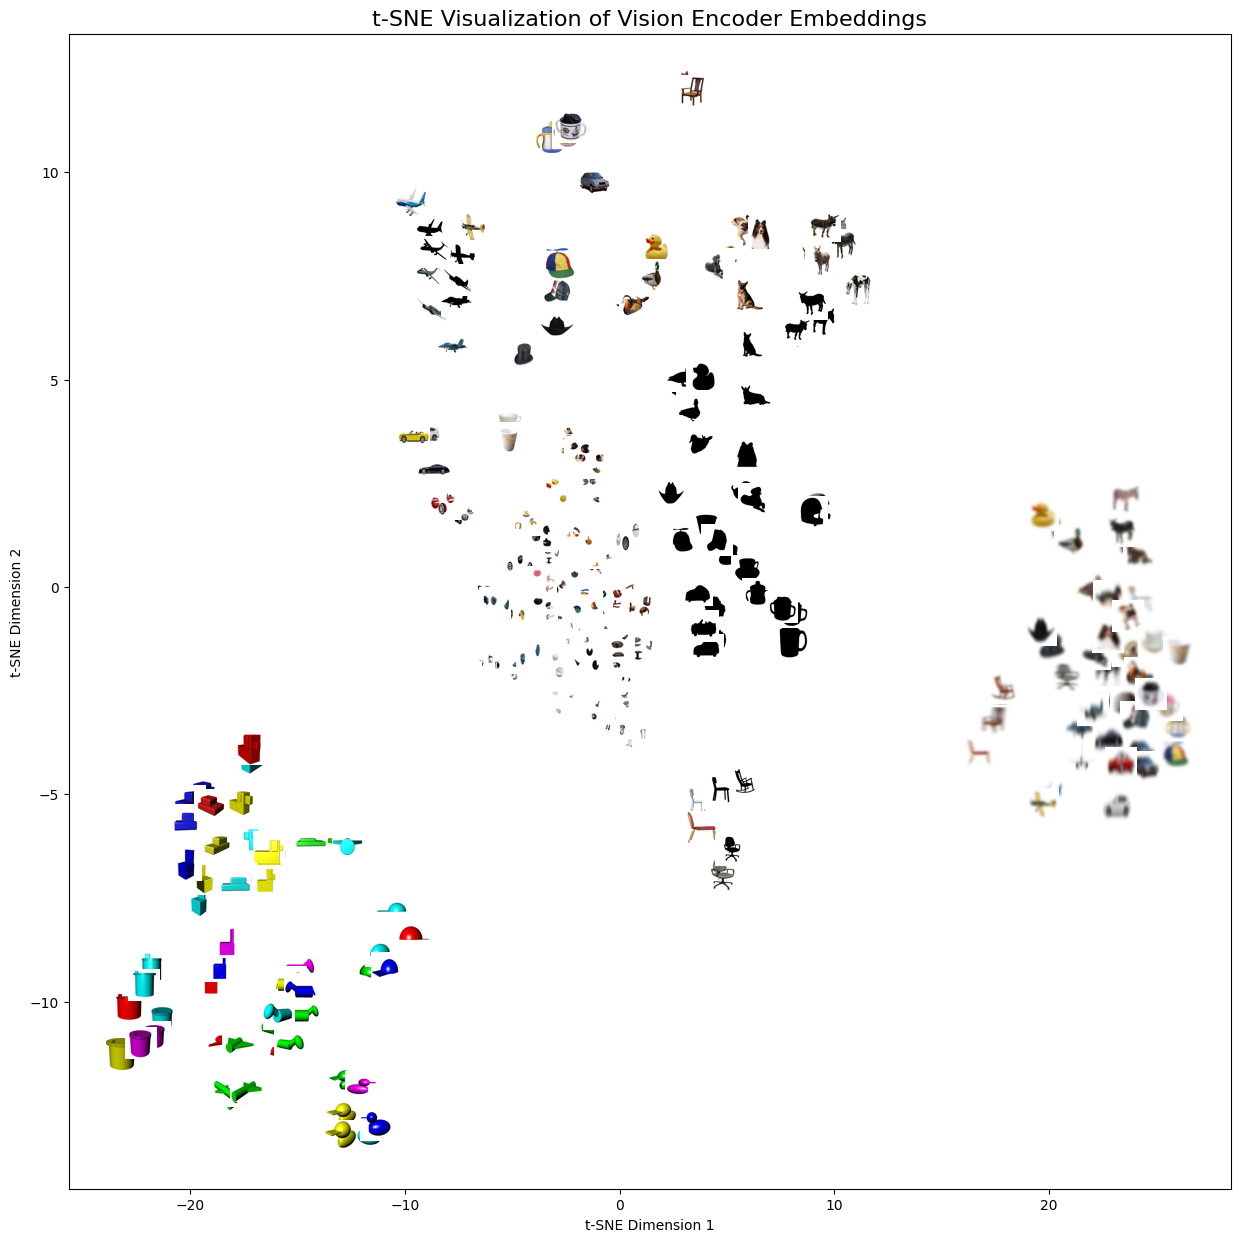

In [26]:
# Define image preprocessing
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for clip-vit-large-patch14
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to match CLIP expectations
])

# Function to extract embeddings from the vision encoder's final layer (before projection)
def extract_embeddings(dataset_dir):
    embeddings = []
    images_raw = []
    image_labels = []

    # Iterate through all conditions and images
    for condition in os.listdir(dataset_dir):
        condition_dir = os.path.join(dataset_dir, condition)
        if not os.path.isdir(condition_dir):
            continue

        for image_file in os.listdir(condition_dir):
            image_path = os.path.join(condition_dir, image_file)

            # Load and preprocess the image
            try:
                image = Image.open(image_path).convert("RGB")
                images_raw.append(image)  # Save raw image for plotting
                image_input = image_transforms(image).unsqueeze(0).to(device)
            except Exception as e:
                print(f"Error loading image {image_file}: {e}")
                continue

            # Extract embeddings from the vision encoder
            with torch.no_grad():
                vision_outputs = model.vision_model(image_input)
                final_layer_output = vision_outputs.last_hidden_state.mean(dim=1).cpu().numpy()  # Pooling
                embeddings.append(final_layer_output[0])
                image_labels.append(image_file)  # Save the image file name as the label

    return embeddings, images_raw, image_labels

# Extract embeddings and raw images
print("Extracting embeddings from the vision encoder...")
embeddings, images_raw, image_labels = extract_embeddings(dataset_dir)

# Convert embeddings list to NumPy array
embeddings = np.array(embeddings)

# Apply t-SNE to reduce embeddings to 2D
print("Applying t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)


# Plot t-SNE results with images
def plot_tsne_with_images(embeddings_2d, images_raw):
    plt.figure(figsize=(15, 15))
    ax = plt.gca()

    for (x, y), image in zip(embeddings_2d, images_raw):
        img = OffsetImage(image.resize((32, 32)), zoom=0.7)  # Resize images for plotting
        ab = AnnotationBbox(img, (x, y), frameon=False)
        ax.add_artist(ab)

    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.0)  # Invisible scatter plot for scaling
    plt.title("t-SNE Visualization of Vision Encoder Embeddings", fontsize=16)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# Plot the t-SNE results
print("Plotting the t-SNE visualization...")
plot_tsne_with_images(embeddings_2d, images_raw)
